<span style="font-family:Papyrus; font-size:3em;">Numerical Analysis of Some Fitting Surfaces</span>

# Preliminaries

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import tellurium as te
import pandas as pd
import seaborn as sn

In [2]:
NRMSE = "nrmse"  # Normalized root of the mean square error (residuals)

# One Species Pathway

Consider the pathway $X0 \xrightarrow{k_1} x \xrightarrow{k_2} X_1$, where $X_0$ and $X1$ have fixed concentrations and reactions kinetics
are mass action with kinetic constants $k_i$.
Then, $\frac{dx}{dt} = k_1 X_0 - k_2 x$.
We want to explore the fitting surface for $k_1, K_2$.

In [3]:
MODEL = """

J1: $X0 -> x; k1*X0
J2: x -> $X1; k2*x

X0 = 1
x = 0
k1 = 1
k2 = 1
"""

In [4]:
PARAMETER_DCT = {"k1": 1, "k2": 1}

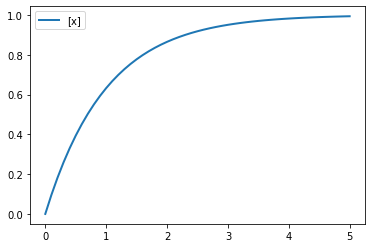

In [5]:
rr = te.loada(MODEL)
trueData = rr.simulate()
rr.plot(trueData)

# ResidualCalculations

In [6]:
def simulateModel(parameterDct, model=MODEL):
    """
    Runs the simulation with the parameter values in the Dct
    
    Parameters
    ----------
    parameterDct
        key: parameterName
        value: value of parameter
        
    Returns
    -------
    NamedArray
    """
    rr = te.loada(model)
    for parameterName, value in parameterDct.items():
        rr[parameterName] = value
    return rr.simulate()

# Test
result = simulateModel({"k1": 1, "k2": 1})
length = len(result)
assert(result[length - 1, -1] > 0.99 )

In [7]:
def getFlatValues(parameterDct, model):
    """
    Provides one dimensional array of simulation results.
    
    Parameters
    ----------
    parameterDct: dict
    model: str
        Antimony string
    """
    data = simulateModel(parameterDct, model=model)
    flattenedArr = (data[:, 1:]).flatten()
    return flattenedArr

# Tests
values = getFlatValues(PARAMETER_DCT, MODEL)
assert(isinstance(values, np.ndarray))  # Is a numpy array
assert(np.isclose(values[0], 0))  # Starts at 0
assert(not np.isnan(sum(values)))  # No nan

In [8]:
def calcNrmse(baseArr, parameterDct, model=MODEL):
    """
    Calculates the R^2 value for the difference between the aseline and parameters.
    
    Parameters
    ----------
    baseArr: flattened array of results for baseline
    parameterDct: dict
        changed parameters
    model: str
         antimony model
         
    Returns
    -------
    float
        root of the mean square error normalized by the variance of the base
    """
    newArr = getFlatValues(parameterDct, model)
    residualsArr = baseArr - newArr
    nrmse = np.var(residualsArr)/np.var(baseArr)
    return nrmse

# Tests
baseArr = getFlatValues(PARAMETER_DCT, MODEL)
nrmse = calcNrmse(baseArr, PARAMETER_DCT)
assert(nrmse == 0.0)
parameterDct1 = {"k1": 2, "k2": 1}
nrmse = calcNrmse(baseArr, parameterDct1)
assert(nrmse > 0.1)

# Experimental Design

Constructs a dataframe where the columns are parameter names and the values are values of the parameter. The middle index is the original value.

In [9]:
def mkParameterRange(initialValue, changeFrc, numPoint):
    """
    Creates an array of values centered on the initial value
    
    Parameters
    ----------
    initialValue: float
    changeFrc: float
        maximum fractional change
    numPoint: int
    
    Result
    ------
    np.array
    """
    if numPoint % 2 == 0:
        numPoint += 1
    maxChange = initialValue*changeFrc
    return np.linspace(start=initialValue-maxChange,
                      stop=initialValue+maxChange,
                      num=numPoint)

# Tests
size = 10
arr = mkParameterRange(2, 0.5, size)
assert(len(arr) == size+1)
assert(arr[0] == 1)

In [10]:
def mkFactorialDesign(parameterDct, maxChangeFrc, numLevel):
    """
    Creates a factorial design for the parameters. Levels are determined
    by fractional changes in the initial value based on the maximum
    fractional change, either positive or negative.
    
    Parameter
    ---------
    parameterDct: dict
    maxChangeFrc: float
        maximum change fraction in positive and negative direction
    numLevel: int
        total number of points in an axis
    
    Returns
    -------
    pd.DataFrame
       Columns:
           parameter name: contains parameter value
           rsq: rsq w.r.t. a change of 0
    """
    # Calculate number of points in one direction
    if numLevel // 2 == 0:
        numHalf = numLevel // 2
    else:
        numHalf = (numLevel - 1) // 2
    #
    incrFrc = maxChangeFrc / numHalf
    posFrcs = np.array([n*incrFrc for n in range(1, numHalf+1)])
    negFrcs = - posFrcs
    negFrcs = np.sort(negFrcs)
    frcs = np.concatenate([negFrcs, np.array([0]), posFrcs])
    # Construct parameter values
    parameterNames = list(parameterDct.keys())
    levelDct = {}
    for parameterName in parameterNames:
        levelDct[parameterName] = (1 + frcs)*parameterDct[parameterName]
    # Construct the parameter columns
    designDF = pd.DataFrame({parameterNames[0]: levelDct[parameterNames[0]]})
    for parameterName in parameterNames[1:]:
        values = levelDct[parameterName]
        dfs = []
        for value in values:
            newDF = designDF.copy()
            newDF[parameterName] = value
            dfs.append(newDF)
        designDF = pd.concat(dfs)
    designDF.index = range(len(designDF))
    # Run the simulations
    return designDF
        
# Tests
numLevel = 5
parameterDct = {"k1": 1, "k2": 2, "k3": 3}
designDF = mkFactorialDesign(parameterDct, 1.0, numLevel)
# Correct length
assert(len(designDF) == numLevel**len(parameterDct))
# First values are 0
trues = [v == 0 for v in designDF.loc[0,:]]
assert(all(trues))
# Middle value is the original value of the parameter
midIdx = (len(designDF) - 1) // 2
trues = [designDF.loc[midIdx, k] == parameterDct[k] for k in parameterDct.keys()]
assert(all(trues))

# Run Experiments

In [12]:
def runExperiments(designDF, model=MODEL, baseParameterDct=PARAMETER_DCT):
    """
    Runs experiments for each combination of parameter values.
    
    Parameters
    ----------
    designDF: pd.DataFrame
        Columns: parameter names
        Values: values of parameter
    model: str
        Antimony model
    baseParameterDct: dict
        baseline values of parameters
        
    Returns
    -------
    simDF: pd.DataFrame
        Columns: parameter names, NRMSE
    """
    baseArr = getFlatValues(baseParameterDct, model)
    #
    nrmses = []
    for idx, rowSer in designDF.iterrows():
        parameterDct = rowSer.to_dict()
        nrmse = calcNrmse(baseArr, parameterDct=parameterDct, model=model)
        nrmses.append(nrmse)
    #
    simDF = designDF.copy()
    simDF[NRMSE] = nrmses
    return simDF
        
#
numLevel = 50
designDF = mkFactorialDesign(PARAMETER_DCT, 1.0, numLevel)
SIM_DF = runExperiments(designDF)

# Visualization

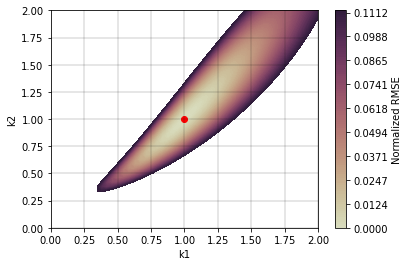

In [24]:
def plotSimDF(simDF, ax=None, fig=None, scale=1.0, isColorBar=True):
    """
    Plots the results of simulation experiments.
    
    Parameters:
    simDF: pd.DataFrame
        Simulation experiments dataframe
        Columns: x axis parameter, y axis parameter
        Values: RSQ
    scale: float in [0, 1]
        Scale the range of values displayed
    """
    # Handle axes and figure
    if (ax is None) or (fig is None):
        fig, ax = plt.subplots(1)
    # Create a table for the contour
    columns = list(simDF.columns)
    rowName = columns[0]
    colName = columns[1]
    df = simDF.copy()
    df = df.astype(float)
    pivotDF = df.pivot_table(values=[NRMSE], columns=[colName], index=[rowName])
    # Construct the contour
    my_cmap = sn.cubehelix_palette(start=3, rot=0.6, reverse=False, as_cmap=True)
    xv = np.array(list(set(simDF[rowName])))
    xv.sort()
    yv = np.array(list(set(simDF[colName])))
    yv.sort()
    zv = pivotDF.to_numpy()
    maxLevel = scale*simDF.max().max()
    levels = [0.01*n*maxLevel for n in range(101)]
    contourPlot = ax.contourf(xv, yv, zv, levels=levels, cmap=my_cmap)
    if isColorBar:
        cbar = plt.colorbar(contourPlot)
        cbar.ax.set_ylabel('Normalized RMSE')
    ax.set_xlabel(rowName)
    ax.set_ylabel(colName)
    # Mark the center
    ax.yaxis.grid(True, linewidth=0.2, linestyle='-', color='0.05')
    ax.xaxis.grid(True, linewidth=0.2, linestyle='-', color='0.05')
    # Mark the center
    xIdx = (len(xv) - 1) // 2
    yIdx = (len(yv) - 1) // 2
    ax.scatter(xv[xIdx], yv[yIdx], color="red")
    return pivotDF

# Tests
df = plotSimDF(SIM_DF, scale=0.001)

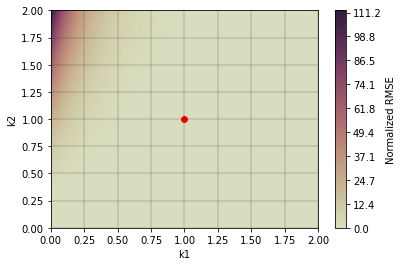

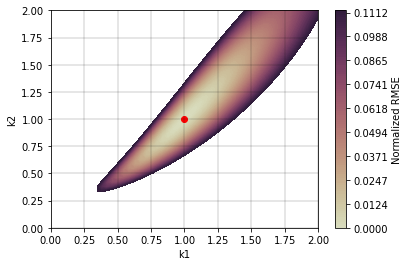

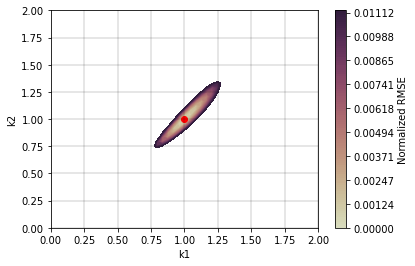

In [26]:
scales = [1, 0.001, 0.0001]
for scale in scales:
    _ = plotSimDF(SIM_DF, scale=scale)

**observations**
1. What happened in the upper left?
1. Convex surface
1. Steeper slope for minima for $k_2$ compared with $k_1$.
1. $R^2$ values are very close together for the half parabola boing through $(1, 1)$.


In [ ]:
df

# Plots

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from math import sin, cos, pi
import matplotlib.cm as cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#creating grid
y = np.linspace(-1,1,200)
x = np.linspace(-1,1,200)
x,y = np.meshgrid(x,y)

#set z values
z0 = x**2+y**2

# rotate the samples by pi / 4 radians around y
if False:
    a = pi / 4
    t = np.transpose(np.array([x,y,z0]), (1,2,0))
    m = [[cos(a), 0, sin(a)],[0,1,0],[-sin(a), 0, cos(a)]]
    x,y,z = np.transpose(np.dot(t, m), (2,0,1))
    # or `np.dot(t, m)` instead `t @ m`


#label axes
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

#plot figure
ax.plot_surface(x,y,z0,linewidth=0, antialiased=False, shade = True, alpha = 0.5, facecolors=cm.viridis(z0))
elevationAng = -140
azimuthAng = 40
ax.view_init(elevationAng, azimuthAng)

plt.show()

In [ ]:
sns.palplot(sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0))

In [ ]:
import numpy as np 
from pandas import DataFrame
import matplotlib.pyplot as plt

index = ['aaa', 'bbb', 'ccc', 'ddd', 'eee']
columns = ['A', 'B', 'C', 'D']
df = DataFrame(abs(np.random.randn(5, 4)), index=index, columns=columns)

plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()


In [ ]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

SIZE = 20
Cols = range(SIZE)
Index= range(SIZE)
df = DataFrame(abs(np.random.randn(SIZE, SIZE)), index=Index, columns=Cols)
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=1, dark=0)

sns.heatmap(df, annot=False, vmin=0, vmax=1.0, cmap=cmap)



In [ ]:
from matplotlib.colors import ListedColormap
x = np.arange(1, 10)
y = x.reshape(-1, 1)
h = x * y
xv = range(9)
yv = range(9)

colorPalette = sn.cubehelix_palette(50, hue=0.05, rot=0, light=1, dark=0)
my_cmap = ListedColormap(colorPalette.as_hex())

fig, ax = plt.subplots(1)
#cs = ax.contourf(h, levels=[5*v for v in range(10)], cmap=my_cmap)
cs = ax.contourf(xv, yv, h, levels=[5*v for v in range(10)], cmap=my_cmap)
#    colors=['#808080', '#A0A0A0', '#C0C0C0'], extend='both')
#cs.cmap.set_over('red')
#cs.cmap.set_under('blue')
cs.changed()
# Colorbar
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel('verbosity coefficient')

# Analysis for One Species

**Result**: Parameter fitting for a one species system is a convex optimization, for certain ranges of $k^{\prime}_2$.
This is best seen by decomposing the problem into two steps.

**Problem setup**
1. The solution to the differential equation is
$x(t) = X_0 \frac{k_1}{k_2}(1 - e^{-k_2 t})$

1. Let $x^{\prime}(t)$ have parameters $k^{\prime}_1$, $k^{\prime}_2$.

1. Define $f(\theta_1, \theta_2) = X_0 \frac{\theta_1}{\theta_2}(1 - e^{-\theta_2 t})$

1. The residuals are $r(t) =  f(k_1, k_2) - f(k^{\prime}_1, k^{\prime}_2)$

1. The sum of squares of the residuals is $R_{SSQ} = \int_0^{\infty} r(t)^2 dt$.


**$k_1 / k_2$ dominates $R_{SSQ}$**

1. For large $t$, $f(\theta_1, \theta_2) \approx X_0 \frac{\theta_1}{\theta_2}$.

1. So, for large $t$, $r(t) \approx X_0 \left( \frac{k_1}{k_2} - \frac{k^{\prime}_1}{k^{\prime}_2} \right)$.
And so, $R_{SSQ} \approx  X_0^2 \left( \frac{k_1}{k_2} - \frac{k^{\prime}_1}{k^{\prime}_2} \right)^2$.

1. This is a convext optimization in the ratios of the parameters.

**Analysis for $\frac{k_1}{k_2} = \frac{k^{\prime}_1}{k^{\prime}_2}$**
1. Assume that $\frac{k_1}{k_2} = \frac{k^{\prime}_1}{k^{\prime}_2}$.
Then, $r(t) =  A( -e^{-k_2 t} + e^{-k^{\prime}_2 t})$, where $A = X_0 \frac{k_1}{k_2}$.

1. $R_{SSQ} = A^2 \int_0^{\infty} \left( e^{-2k_2 t} -2 e^{-(k_2 + k^{\prime}_2)t} + e^{-2k^{\prime}_2t} \right)$

1. And so, $R_{SSQ} = A^2 \left( - \frac{1}{2k_2} e^{-2k_2 t} +  \frac{2}{k_2 + k^{\prime}_2} e^{-(k_2 + k^{\prime}_2)t} - \frac{1}{2k^{\prime}_2} e^{-2k^{\prime}_2t} \right) \biggr\vert_0^{\infty}$

1. $R_{SSQ} = A^2 \left( \frac{1}{2k_2} -  \frac{2}{k_2 + k^{\prime}_2} + \frac{1} {2 k^{\prime}_2}  \right)$


**Claim:** $\frac{1}{2 x} -  \frac{2}{x + y} + \frac{1} {2 y} \geq 0$ for $x, y > 0$.

1. The claim is equivalent to: $y(x + y) - 4 x y + x (x + y ) \geq 0$.

1. Or, $y^2 - 2xy + x^2 + xy - 2xy + xy = (y - x)^2 \geq 0$.

**Is**: $R_{SSQ}$ is convex in $k^{\prime}_2$?

1. Claim that $\frac{\partial T_{SE}}{\partial k^{\prime}} \geq 0$.

1. Note that $\frac{\partial^2 R_{SSQ}}{\partial^2 k^{\prime}_2} 
= A^2 \left( \frac{1}{k^3_2} -  \frac{4 }{(k_2 + k^{\prime}_2)^3} + \frac{1} {( k^{\prime}_2)^3}  \right)$

Generalize this to cases where the ratios are not equal?

**General Argument for Convex**

1. $L(k^{\prime}) = \int_0^{\infty} r^2(t)$, where
$r(t) = x(t) - x^{\prime} (t) = X_0 \frac{k_1}{k_2}(1 - e^{-k_2 t} )- X_0 \frac{k^{\prime}_1}{k^{\prime}_2}(1 - e^{-k^{\prime}_2 t})$
1. Note that
   1. $e^{-xt}$ is convex in $x$
   1. What about $\frac{-1}{x}$, for $x>0$? It seems that the local minima is the global minima.


# Notes

1. Objectives
   1. Research - relate that nature of the fitting surface to the chemical network. Show in which cases the fitting surface is convex. Provide insights into strategies for fitting.
   1. Teaching - provide insights into what is happening with the different fitting algorithms by animating their steps.
   
1. Research directions
   1. Fitting surfaces by network type: linear, branched, feedback.
   1. Preliminary insights
      1. Detecting easily fit networks
      1. When do starting positions matter. For which parameters (because of combinatorics). How narrow parameter ranges (to reduce combinatorics).
      
1. A strategy for a linear chain (and maybe more general networks) is to first optimize the ratio of species concentrations.
But which ratios?

1. To do
    1. Show simulations for different points in the curve, relating the simulation results to $R^2$.
    1. Look at longer linear chains.
    1. Examine Wolf model